In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2 
import pygame 
import math
import os
import image_slicer
import cv2.cv as cv
import glob
import operator 
from __future__ import division
from array import array

%matplotlib inline  


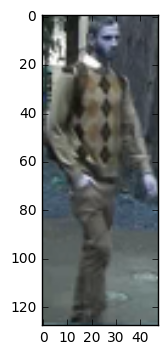

(128, 48, 3)

In [2]:
# load the images

filelist = glob.glob('C:/Users/ahmad/Desktop/Human-Re-id/*.bmp')
X = np.array([np.array(cv2.imread(fname)) for fname in filelist])
plt.imshow(X[1])
plt.show()


X[0].shape

In [3]:
# CROP the images into subregions 

def cropImage(image):
    #del patches
    
    col_num = image.shape[0] // 6
    area1 = 0
    patches = []

    for i in range (0,6): 
        area1 = i * col_num

        if i != 5:
            sub_regions = image[area1:area1 + col_num, :]
        else:
            sub_regions = image[area1:, :]

        patches.append(sub_regions)

    patches = np.array(patches)


    return patches

In [4]:
# function for building the filter for gobor feature

def build_filters():
    """ returns a list of kernels in several orientations
    """
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 32):
        params = {'ksize':(ksize, ksize), 'sigma':1.0, 'theta':theta, 'lambd':15.0,
                  'gamma':0.02, 'psi':0, 'ktype':cv2.CV_32F}
        kern = cv2.getGaborKernel(**params)
        kern /= 1.5*kern.sum()
        filters.append((kern,params))
    return filters

In [5]:
# function for compute the gobor feature

def process(img, filters):
    """ returns the img filtered by the filter list
    """
    accum = np.zeros_like(img)
    for kern,params in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [6]:
# Features Extractions

all_ffimage = []
filters = build_filters()



for i in range(len(X)):
    
    ful_features = []
    patches = cropImage(X[i])
    
    #plt.imshow(patches[0])
    #plt.show()
    
        
    for j in range(len(patches)):
        
        # extract  the features 
        
        rgb      = cv2.cvtColor(patches[j],cv2.COLOR_BGR2RGB)
        histb = cv2.calcHist([rgb],[0],None,[256],[0,256])        # <<<<< (256, 1)
        histg = cv2.calcHist([rgb],[1],None,[256],[0,256])        # <<<<< (256, 1)
        histr = cv2.calcHist([rgb],[2],None,[256],[0,256])        # <<<<< (256, 1)
        
        hsv      = cv2.cvtColor(patches[j], cv2.COLOR_BGR2HSV)
        histhsvb = cv2.calcHist([hsv], [0], None, [8], [0, 256])   #<<<<<(8,1)
        histhsvg = cv2.calcHist([hsv], [1], None, [8], [0, 256])   #<<<<<(8,1)
        histhsvr = cv2.calcHist([hsv], [2], None, [8], [0, 256])   #<<<<<(8,1)
        
        gray     = cv2.cvtColor(patches[j], cv2.COLOR_BGR2GRAY)
        histgray = cv2.calcHist([gray],[0],None,[256],[0,256])     # <<<<< (256, 1)
        
        gobor   = process(patches[j], filters)

        # convert feature to vector 

        #rgbv    = (rgb.reshape((rgb.shape[0]*rgb.shape[1]*rgb.shape[2], 1))).T
        #hsvv    = (hsv.reshape((hsv.shape[0]*hsv.shape[1]*hsv.shape[2], 1))).T
        #grayv   = (gray.reshape((gray.shape[0]*gray.shape[1], 1))).T
        goborv  = (gobor.reshape((gobor.shape[0]*gobor.shape[1]*gobor.shape[2], 1))).T
        
        features = np.hstack((histb.T,histg.T,histr.T,histhsvb.T,histhsvg.T,histhsvr.T,histgray.T,goborv)) 
        
        ful_features.append(features)
        
    ffimage = np.hstack((ful_features[0],ful_features[1],ful_features[2],ful_features[3],ful_features[4],ful_features[5]))
    all_ffimage.append(ffimage)
    #patches = list(patches)
    
    

In [7]:
X_f = np.array(all_ffimage)
#X = np.squeeze(X, axis=1)
X_f = np.asmatrix(X_f)


print(X_f.shape)

(1263, 24720)


# KNN

In [8]:
# divide the date to train set and test set 

#XTrain = X_f[:884]
#XTest = X_f[884:]
#print(XTrain.shape)
#print(XTest.shape)


In [12]:
# function to calculate the Euclidean Distance

def euclideanDistance(example1, examples2):
    distance = np.linalg.norm(example1 - examples2)
    return distance

In [13]:
# function to compute the Nighbors

def getNeighbors(ImagesSet, reqImage , k):
    distances = []
    
    for x in range(len(ImagesSet)):
        dist = euclideanDistance(reqImage, ImagesSet[x])
        distances.append((ImagesSet[x], dist , x))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x])
    neighbors = np.array(neighbors)
    return neighbors

The index of the matched image in the input images  = 2


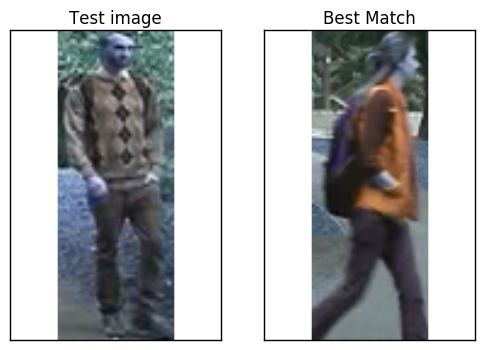

The index of the matched image in the input images  = 0


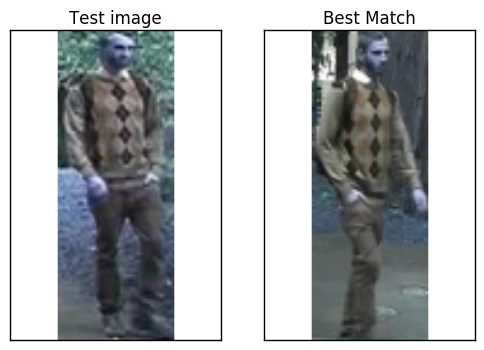

The index of the matched image in the input images  = 4


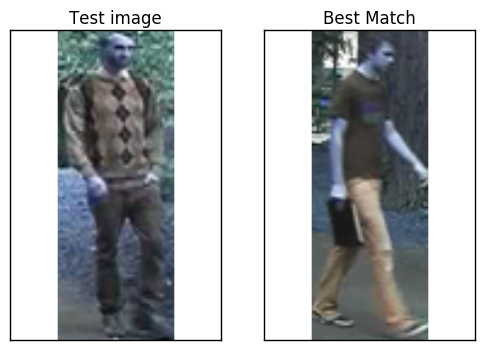

In [14]:
testimage  = X[0]
imagesets  = X[1:]

testimagef = X_f[0]
imagesetsf  = X_f[1:10] 


neighbors  = getNeighbors(imagesetsf, testimagef, 3)


# plot the images


for x in range(len(neighbors)):
    print ("The index of the matched image in the input images  = " + str(neighbors[x, 2]))
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.set_title('Test image')
    ax2.set_title('Best Match')
    
    ax1.xaxis.set_visible(False)
    ax2.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    
    ax1.imshow(testimage)
    ax2.imshow(imagesets[neighbors[x, 2]])
    plt.show()